In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
EPOCHS     = 40
BATCH_SIZE = 64

In [ ]:
transform_CIFAR10 = transforms.Compose([
    transforms.ToTensor()
])
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root      = './data_CIFAR10', 
        train     = True,
        download  = True,
        transform = transform_CIFAR10),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root      = './data_CIFAR10', 
        train     = False,
        download  = True,
        transform = transform_CIFAR10),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


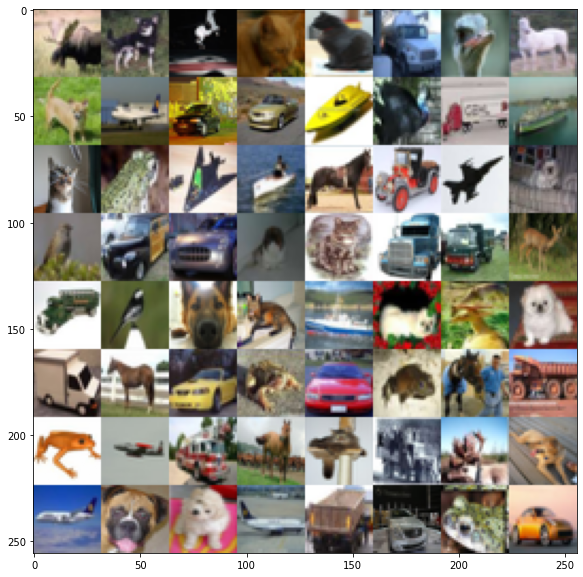

[[' deer' '  dog' 'horse' '  cat' '  cat' 'truck' ' bird' 'horse']
 ['  dog' 'plane' '  car' '  car' ' ship' ' bird' 'truck' ' ship']
 ['  cat' ' frog' 'plane' ' ship' 'horse' 'truck' 'plane' '  dog']
 [' bird' '  car' '  car' '  dog' '  cat' 'truck' 'truck' ' deer']
 ['truck' ' bird' '  dog' '  cat' ' ship' '  dog' ' deer' '  dog']
 ['truck' 'horse' '  car' ' frog' '  car' ' frog' 'horse' 'truck']
 [' frog' 'plane' 'truck' 'horse' '  cat' 'truck' ' deer' '  dog']
 ['plane' '  dog' '  dog' 'plane' 'truck' '  car' ' frog' '  car']]


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
classes = np.array(['plane', '  car', ' bird', '  cat', ' deer',
                    '  dog', ' frog', 'horse', ' ship', 'truck'])
print(classes[labels.reshape((8, 8))])

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 24, kernel_size=3)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(4056, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, 4056)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
model     = CNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
            Conv2d-2           [-1, 16, 28, 28]           1,168
            Conv2d-3           [-1, 24, 26, 26]           3,480
         Dropout2d-4           [-1, 24, 26, 26]               0
            Linear-5                  [-1, 128]         519,296
            Linear-6                   [-1, 10]           1,290
Total params: 525,458
Trainable params: 525,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 2.00
Estimated Total Size (MB): 2.42
----------------------------------------------------------------


In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.274149
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.287374
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.192160
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.044484
[1] Test Loss: 2.1418, Accuracy: 20.62%
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.148230
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.024522
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.041606
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.049376
[2] Test Loss: 1.8229, Accuracy: 37.28%
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.870641
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.811084
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.742804
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.721851
[3] Test Loss: 1.7413, Accuracy: 39.25%
Train Epoch: 4 [0/50000 (0%)]	Loss: 2.183404
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.859127
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.939779
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.708244
[4] Test Loss: 1.6385, Accuracy: 44.12%
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.642550
Train Epoch: 5 

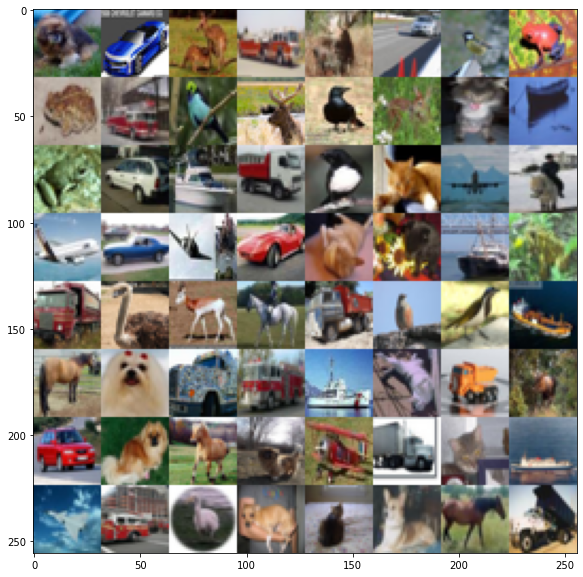

your predict : 
[['horse' '  car' '  dog' 'truck' ' deer' 'truck' ' bird' ' frog']
 [' frog' 'truck' ' frog' ' deer' '  dog' ' deer' '  cat' 'plane']
 [' frog' '  car' ' ship' 'truck' '  dog' '  cat' 'plane' '  cat']
 ['plane' 'truck' '  cat' '  car' '  dog' '  cat' ' ship' ' frog']
 ['truck' '  dog' '  dog' 'horse' 'truck' ' bird' ' bird' ' ship']
 ['horse' '  dog' 'truck' 'truck' ' ship' '  cat' 'truck' ' deer']
 ['  car' '  cat' 'horse' ' frog' '  dog' ' ship' 'truck' ' ship']
 ['plane' '  car' 'truck' ' frog' ' deer' '  cat' 'horse' 'truck']]

answer : 
[['  dog' '  car' ' deer' 'truck' ' deer' '  car' ' bird' ' frog']
 [' frog' 'truck' ' bird' ' deer' ' bird' ' deer' '  cat' ' ship']
 [' frog' '  car' ' ship' 'truck' ' bird' '  cat' 'plane' 'horse']
 ['plane' '  car' 'plane' '  car' '  cat' '  dog' ' ship' ' frog']
 ['truck' ' bird' ' deer' 'horse' 'truck' ' bird' ' bird' ' ship']
 ['horse' '  dog' 'truck' 'truck' ' ship' '  cat' 'truck' ' deer']
 ['  car' '  dog' 'horse' '  dog' 

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
your_predict = model(images.to(DEVICE)).max(1)[1].view(8, 8).cpu()
answer = labels.reshape((8, 8))
correct = your_predict == answer
print("your predict : ")
print(classes[your_predict])
print("\nanswer : ")
print(classes[answer])
print("\ncorrectness :", correct.sum().item()/64)
print(correct)